In [1]:
%load_ext autoreload
%autoreload 2

import __confing
__confing.change_to_root_folder()

Current directory: c:\Users\Leo\OneDrive\Escritorio\Final Proyect


In [2]:
try:
    __confing.execute_notebook('notebooks/data_extract.ipynb')
except:
    pass

In [3]:
import pandas as pd
import numpy as np

from src import value_filler as vf
from src import feature_selection as fs
from src import data_procces as dp

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error,roc_auc_score,confusion_matrix,recall_score,confusion_matrix,f1_score 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def feature_importance(model, X: pd.DataFrame, y: pd.Series, n: int):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    feature_names_original = list(X.columns)
    
    target_name = y.name  # Obtener el nombre de la columna objetivo desde la Serie y
    
    if target_name in feature_names_original:
        feature_names_original.remove(target_name)
    
    max_importance = list(indices[:n])
    
    nueva_lista = [feature_names_original[i] for i in max_importance]
    
    return nueva_lista

def proba_dist(model, X_test):
    with plt.style.context('fivethirtyeight'):
        sns.histplot(model.predict_proba(X_test), bins=-50)
        plt.title("Probability distribution for each Target category")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        plt.show()


In [5]:
n='a'
df=pd.read_csv(r'data\custom\all_waves.csv')
df = df.loc[df['paagey'] >= 50]
target=f'p{n}hosp1y'

In [6]:
selected=['pahosp1y','pahipe_m', 'padadage', 'pamomage', 'pahibpe', 'palunge_m', 'pacholst', 'pagrossaa', 'paosleep', 'pafallinj', 'pacancre', 'paswell', 'pachair', 'parafaany', 'pawheeze', 'paagey', 'paarthre', 'padiabe', 'parjudg', 'paweight', 'paclims', 'pastroke', 'pabathehlp', 'pasmokev', 'pahearaid', 'pameds', 'paheight', 'paglasses', 'paeat', 'papaina', 'pagender', 'padrinkb']
len(selected)

32

In [7]:
df3 = df.where(df['cpindex'] <=  107.69).dropna(subset=['cpindex'])

In [8]:
selected = list(set(selected))

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

In [9]:
porcentaje_nulos = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (porcentaje_nulos <= 0.5)]

In [10]:
# fill
y = df_s[target]
X = df_s.drop(target,axis=1)

In [11]:
X = fs.fast_fill(X)
X=X.sort_index(axis=1)

In [12]:
scaler = StandardScaler()
X=scaler.fit_transform(X)

transformer = PowerTransformer(method='yeo-johnson')
X=transformer.fit_transform(X)
pass

In [13]:
zeros=y.value_counts()[0]
unos=y.value_counts()[1]

In [63]:
params={
        'max_depth': 8, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.05568753700048324, 
        'min_child_weight': 5, 
        'learning_rate': 0.0999908981133205, 
        'n_estimators': 560,
        'scale_pos_weight': (zeros/unos)-2.5, # 
        'n_jobs':-1
}

model = XGBClassifier(**params)

In [64]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=7)

results = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # X_train, y_train = dp.apply_smote(X_train, y_train) el smote es malo en este caso
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append(auc)

In [65]:
cv_score = np.mean(results)
print('AUC Score:', cv_score)

AUC Score: 0.9387559827123356


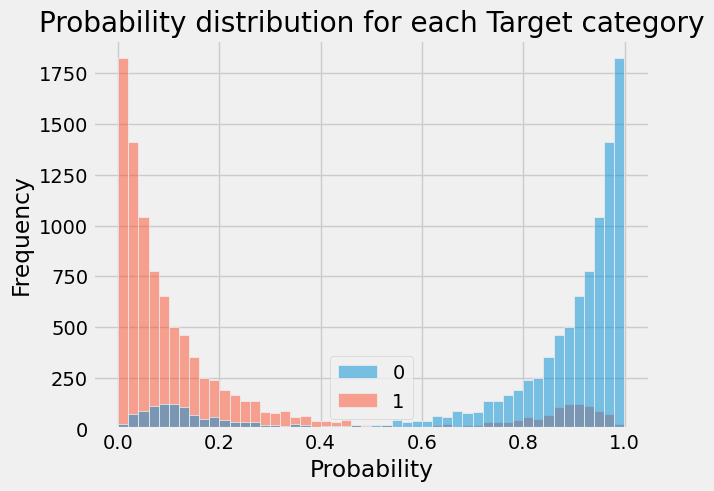

In [66]:
proba_dist(model, X_test)

In [67]:
# model.save_model('try kfold/model_k2.xgb')
# joblib.dump(scaler,'try kfold/scaler_k.pkl')
# joblib.dump(transformer,'try kfold/transformer_k.pkl')

['try kfold/transformer_k.pkl']

In [70]:
params = model.get_params()

In [71]:
params

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9075616505206274,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.0999908981133205,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 560,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 5.893429158110884,
 'subsample': 0.759545947005226,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 